In [1]:
import pandas as pd
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib qt5
%matplotlib inline

In [35]:
raw = pd.read_csv('./creditcard.csv')

In [36]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


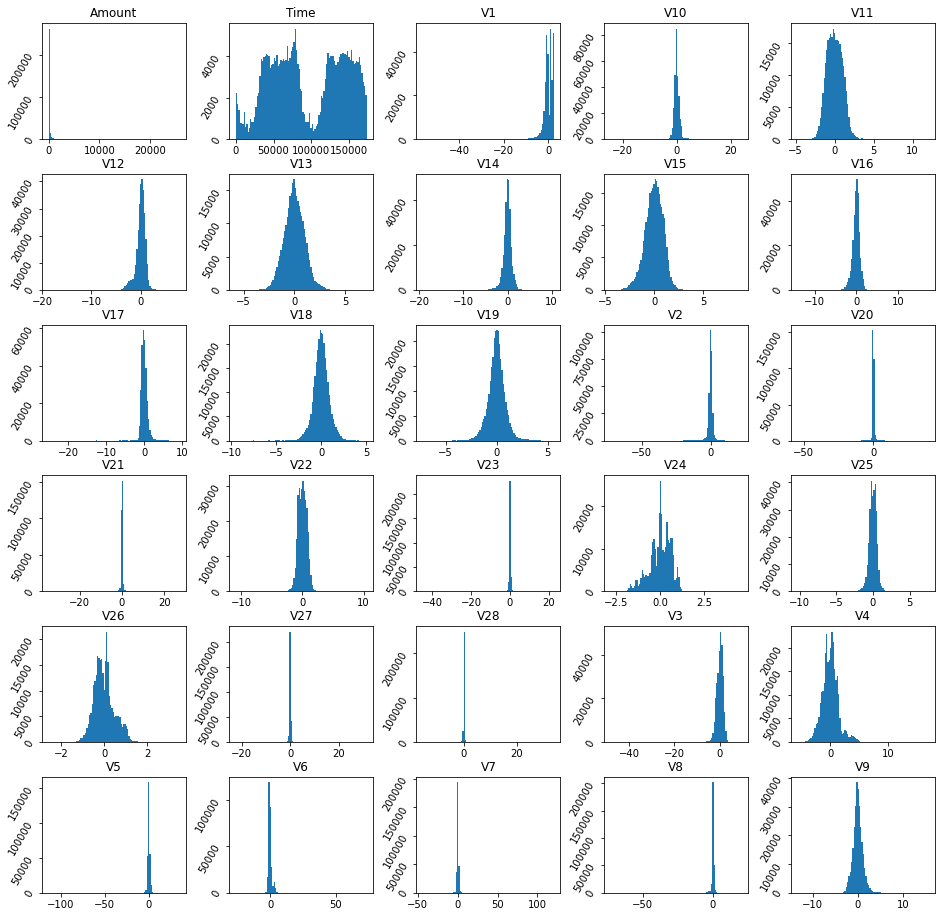

In [6]:
## 查看整体数据分布
_ = raw.iloc[:,:-1].hist(grid=False,yrot=60,figsize=(16,16),layout=(6,5),bins=100)

<AxesSubplot:>

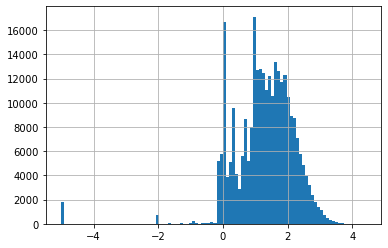

In [43]:
## 数据说明中，Amount和Time未处理，上面图看出可以把Amout变换到近似到正态分布。
raw.Amount.transform(lambda x: np.log10(x+1e-5)).hist(bins=100)

<AxesSubplot:>

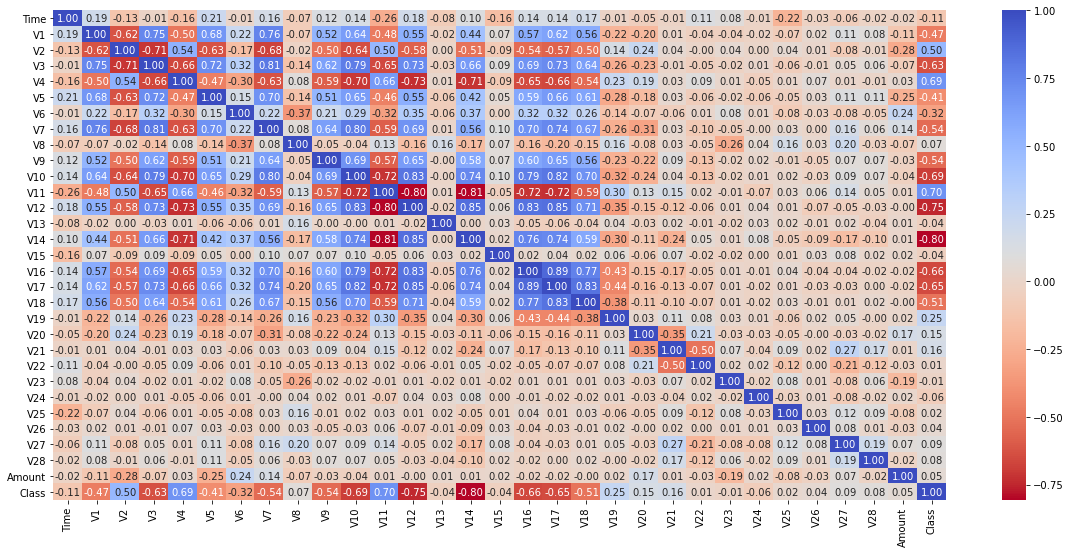

In [44]:
## 降采样取得近似平衡样本集
b_df = pd.concat([raw.query('Class==0').sample(frac=.01),raw.query('Class==1')])
## 查看平衡数据集中相关系数矩阵
plt.figure(figsize=(20,9))
sns.heatmap(b_df.corr(),cmap='coolwarm_r',annot=True,fmt='.2f')
## 个别特征有较强共线性，但是维度不多，不需要降维了

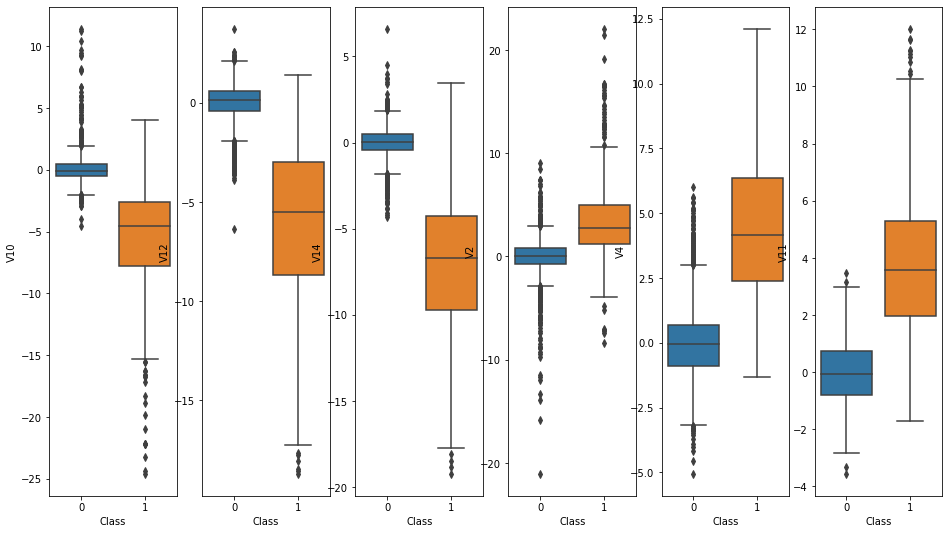

In [10]:
## 查看个别明显特征的数据分布
plt.figure(figsize=(16,9))
for i,v in enumerate(['V10','V12','V14','V2','V4','V11']):
    plt.subplot(1,6,i+1)
    sns.boxplot(x='Class',y=v,data=b_df)

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30)

In [54]:
def tsne_plot(tsne, X,y):
    embedded = np.c_[tsne.fit_transform(X), y]
    embedded = pd.DataFrame(embedded,columns=list('abc'))
    embedded.plot.scatter('a','b',c='c',cmap='viridis')
    return 
## 看出可以分类

# 非监督学习方法

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [31]:
## 数据准备
## 训练集：60%正常数据
## 验证集：20%正常+50%异常
## 测试集：20%正常+50%异常
class DATA1():
    def __init__(self,raw=raw):
        raw['Amount'] = np.log10(raw.Amount+1e-5)
        raw.drop('Time',axis=1,inplace=True)
        
        Fraud, Normal = raw.query('Class==1'), raw.query('Class==0')
        self.X_train,Normal40 = train_test_split(Normal,test_size=.4)
        Fraud1,Fraud2 = train_test_split(Fraud,test_size=.5)
        Normal1,Normal2 = train_test_split(Normal40,test_size=.5)
        self.X_valid = pd.concat([Fraud1,Normal1])
        self.X_test = pd.concat([Fraud2,Normal2])
        
        self.y_train = self.X_train.pop('Class')
        self.y_valid = self.X_valid.pop('Class')
        self.y_test = self.X_test.pop('Class')
        
    def fit_transform(self,estimator=StandardScaler()):
        self.estimator = estimator
        self.estimator.fit(self.X_train)
        
        self.X_train = self.estimator.transform(self.X_train)
        self.X_valid = self.estimator.transform(self.X_valid)
        self.X_test = self.estimator.transform(self.X_test)
        
        return self.estimator
        

In [37]:
data1 = DATA1(raw.copy())
data1.fit_transform(StandardScaler())

StandardScaler()

D:\Program Files\Anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
D:\Program Files\Ana

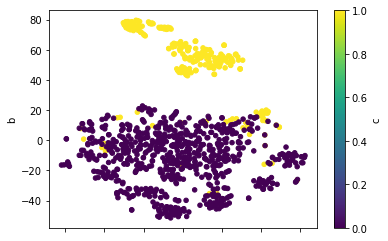

In [56]:
tsne_plot(tsne,data1.X_test[:1000],data1.y_test[:1000])
## 大致可分

## AutoEncoder

In [59]:
import torch as t
import torch.utils.data as Data

### 定义

In [61]:
BATCH_SIZE=256
EPOCHS = 100

class CCFD(Data.Dataset):
    def __init__(self,X_train:np.array):
        self.data = t.from_numpy(X_train).float()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,i):
        return self.data[i]
    
train_db = CCFD(data1.X_train)
valid_db = CCFD(data1.X_valid)

In [62]:
class AE(t.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.encoder = t.nn.Sequential(
            t.nn.Linear(input_dim,16),
            t.nn.ReLU(),
            t.nn.Linear(16,8),
            t.nn.ReLU(),
            t.nn.Linear(8,2),
            t.nn.ReLU())
        
        self.decoder = t.nn.Sequential(
            t.nn.Linear(2,8),
            t.nn.ReLU(),
            t.nn.Linear(8,16),
            t.nn.ReLU(),
            t.nn.Linear(16,input_dim))
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
autoencoder = AE(input_dim = data1.X_train.shape[1])
optimizer = t.optim.Adam(autoencoder.parameters(),lr=5e-3)
loss_func = t.nn.MSELoss()

train_loader = Data.DataLoader(train_db,batch_size=BATCH_SIZE,shuffle=True)

### 训练集训练

In [63]:
for epoch in range(EPOCHS):
    
    for step, x in enumerate(train_loader):
        
        b_x, b_y = x.view(*x.shape), x.view(*x.shape)
        
        ## 计算输出
        encoded, decoded = autoencoder.forward(b_x)
        ## 计算误差
        loss = loss_func(decoded, b_y)
        ## 反向传播
        loss.backward()
        ## 更新参数
        optimizer.step()
        ## 清除梯度
        optimizer.zero_grad()
        
    y_valid = autoencoder.forward(valid_db.data)[1]
    loss_valid = loss_func(y_valid, valid_db.data).detach().numpy()
#     print(f'Epoch: {epoch}, | val loss: {loss_valid:.4f}')

### 验证集选阈值

In [144]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, confusion_matrix, precision_recall_fscore_support

In [79]:
def ae_error(estimator, X, y):
    _, pred = estimator.forward(t.Tensor(X))
    residual = (pred.detach()-X).square().mean(1).detach().numpy()
    error = y.to_frame().assign(pred = residual)
    return error

In [81]:
error = ae_error(autoencoder, data1.X_valid, data1.y_valid)
error.head()

,Class,pred
151011,1,76.729421
154720,1,23.935384
144104,1,16.433566
212516,1,10.749409
96341,1,0.193145


In [103]:
def thre_f1(error):
    p, r, thre = precision_recall_curve(error.Class,error.pred)
    f1 = 2*p*r/(p+r+1e-5)
    ax=PrecisionRecallDisplay(p,r).plot()
    plt.plot(r, f1,label='f1-score')
    idmax = f1.argmax()
    plt.scatter(r[idmax], f1[idmax], marker='o', color='g', 
                label=f'Best f1-score:{f1[idmax]:.3f}\nThreshold:{thre[idmax]:.3f}')
    plt.legend()
    return thre[idmax]

10.13072739241967

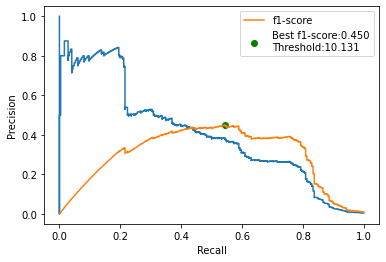

In [104]:
thre = thre_f1(error)
thre

### 测试集表现

In [105]:
test_error = ae_error(autoencoder,data1.X_test,data1.y_test)

In [107]:
test_error['PRED'] = test_error.pred>thre
a=confusion_matrix(test_error.Class,test_error.PRED);a

array([[56632,   231],
       [  125,   121]], dtype=int64)

In [245]:
def summary(confusion):
    r = confusion[1,1]/confusion[1,:].sum()
    p = confusion[1,1]/confusion[:,1].sum()
    f1 = 2*p*r/(p+r)
    print(f'P: {p:.3f},\nR: {r:.3f},\nF1-SCORE: {f1:.3f}')
    return

In [114]:
summary(a) ## 效果太差了，放弃

P: 0.344,
R: 0.492,
F1-SCORE: 0.405


## Gaussian Mixture

### 模型定义

In [232]:
from scipy.stats import multivariate_normal as mn

class myGM:
    def __init__(self,thre=.5):
        self.thre = thre
        pass
    
    def fit(self, X, y=None):
        X_ = pd.DataFrame(X)
        self.mu = X_.mean().values
        self.cov = X_.cov().values
        return self
    
    def predict_pdf(self, X, y=None):
        pdf = mn.pdf(X, self.mu, self.cov)
        return pdf
    
    def predict(self,X):
        pdf = self.predict_pdf(X)
        return (pdf<self.thre).astype(int)

### 训练集训练

In [205]:
mygm = myGM()
mygm.fit(data1.X_train)

### 验证集找阈值

In [227]:
def gm_thre_fi1(estimator, X, y):
    pred = estimator.predict_pdf(X)
    error = y.to_frame().assign(pred = pred)
    
    error.sort_values('pred', ascending=True,inplace=True)
    t = error.pred
    p = error.expanding()['Class'].mean()
    r = error.Class.cumsum()/error.Class.sum()
    f1 = 2*p*r/(p+r)
    
    PrecisionRecallDisplay(p,r).plot()
    plt.plot(r,f1,label='f1-score')
    idmax = f1.idxmax()
    plt.scatter(r[idmax], f1[idmax], marker='o', color='g', 
                label=f'Best f1-score:{f1[idmax]:.3f}')
    plt.legend()
    return t[idmax]

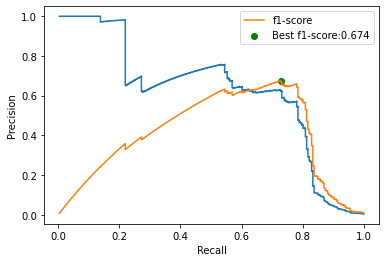

In [247]:
mygm.thre = gm_thre_fi1(mygm, data1.X_valid, data1.y_valid)

### 测试集评估

In [250]:
print(confusion_matrix(data1.y_test, mygm.predict(data1.X_test)))
summary(confusion_matrix(data1.y_test, mygm.predict(data1.X_test)))
## 比随机分要好一点

[[56758   105]
 [   75   171]]
P: 0.620,
R: 0.695,
F1-SCORE: 0.655


# 监督学习方法

## 重新划分

In [253]:
## 数据准备
## 训练集：75%正常+75%异常
## 测试集：25%正常+25%异常
class DATA2():
    def __init__(self,raw=raw):
        raw['Amount'] = np.log10(raw.Amount+1e-5)
        raw.drop('Time',axis=1,inplace=True)
        
        self.X_train, self.X_test = train_test_split(raw, 
                                        stratify=raw.Class)       
        self.y_train = self.X_train.pop('Class')
        self.y_test = self.X_test.pop('Class')
        
    def fit_transform(self,estimator=StandardScaler()):
        self.estimator = estimator
        self.estimator.fit(self.X_train)
        
        self.X_train = self.estimator.transform(self.X_train)
        self.X_test = self.estimator.transform(self.X_test)
        
        return self.estimator

In [274]:
data2 = DATA2(raw.copy())
data2.fit_transform(StandardScaler())

StandardScaler()

In [266]:
## 定义评估函数
def metric(estimator, X_test, y_test):
    plt.figure(figsize=(16,5))
    ax1=plt.subplot(121)
    plot_precision_recall_curve(estimator,X_test,y_test,ax=ax1)
    ax2 = plt.subplot(122)
    ax = plot_confusion_matrix(estimator,X_test,y_test,ax=ax2)
    summary(ax.confusion_matrix)
    return 

In [262]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

## LogisticRegression

In [255]:
from sklearn.linear_model import LogisticRegression

In [275]:
lr = LogisticRegression()
params = {'C':[.1,1,10]}
lr_clf = GridSearchCV(lr,params,scoring='f1',n_jobs=-1)
lr_clf.fit(data2.X_train,data2.y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10]}, scoring='f1')

In [276]:
print(clf.best_params_, clf.best_score_)

{'C': 10} 0.7125717974429568


P: 0.894,
R: 0.618,
F1-SCORE: 0.731


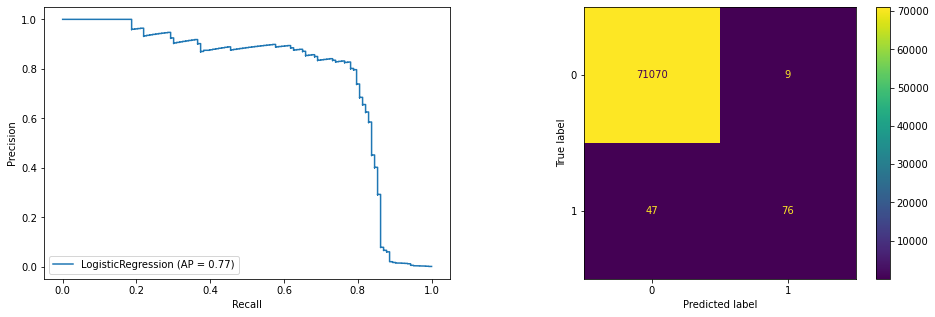

In [277]:
metric(lr_clf.best_estimator_, data2.X_test, data2.y_test)

### SMOTE OR NOT

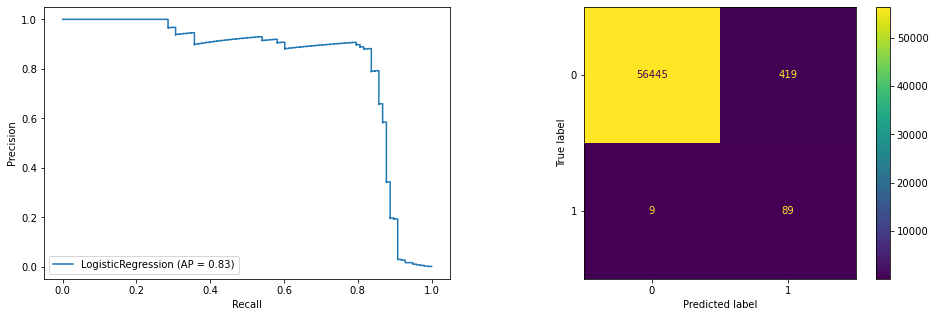

In [595]:
from imblearn.over_sampling import SMOTE,RandomOverSampler

smote = RandomOverSampler(sampling_strategy=.3)
# smote = SMOTE(sampling_strategy=.3)
train_smoted = smote.fit_resample(X_train, df_train.Class)

lr = LogisticRegression()
params = {'C':[.001,.01,.1,1,10]}
clf = GridSearchCV(lr,params,scoring='f1',n_jobs=-1)
clf.fit(*train_smoted)

plt.figure(figsize=(16,5))
ax1 = plt.subplot(121)
plot_precision_recall_curve(clf.best_estimator_,X_test,df_test.Class,ax=ax1)
ax2 = plt.subplot(122)
plot_confusion_matrix(clf.best_estimator_,X_test,df_test.Class,ax=ax2)

In [596]:
summary(np.array([[56429,435],[11,87]])) ## 效果比未拓展时更差了

P: 0.888,
R: 0.167,
F1-SCORE: 0.281


## SVM

In [278]:
from sklearn.svm import SVC

In [280]:
svc = SVC(probability=True)
svc.fit(data2.X_train, data2.y_train)

SVC(probability=True)

P: 0.942,
R: 0.659,
F1-SCORE: 0.775


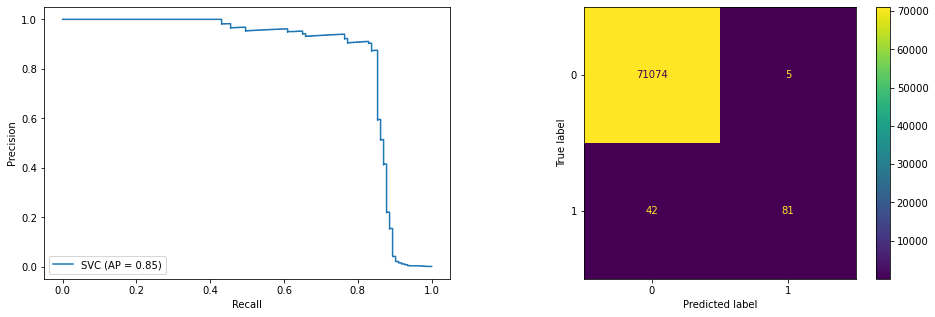

In [281]:
metric(svc,data2.X_test, data2.y_test)

## IsoForest

In [282]:
from sklearn.ensemble import IsolationForest

In [283]:
iforest = IsolationForest()
iforest.fit(data1.X_train)

IsolationForest()

In [284]:
summary(confusion_matrix(data1.y_test,(iforest.predict(data1.X_test)==-1).astype(int)))

P: 0.079,
R: 0.833,
F1-SCORE: 0.144


## XGBoost

In [288]:
from xgboost import XGBClassifier

In [289]:
xgb = XGBClassifier()
params = {'n_estimators':[100,150],'max_depth':[4,5,6]}
xgb_clf = GridSearchCV(xgb,params,n_jobs=-1,scoring='f1')
xgb_clf.fit(data2.X_train, data2.y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [598]:
xgb = xgb_clf.best_estimator_

P: 0.925,
R: 0.805,
F1-SCORE: 0.861


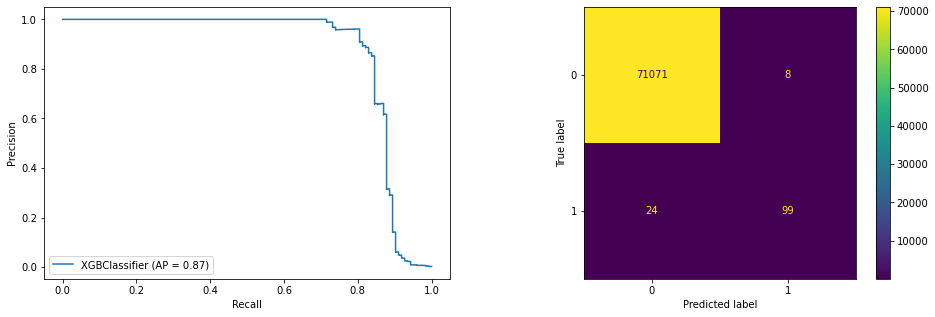

In [292]:
metric(xgb_clf.best_estimator_, data2.X_test, data2.y_test)

## Adaboost

In [294]:
from sklearn.ensemble import AdaBoostClassifier

In [295]:
adb = AdaBoostClassifier(n_estimators=100)
params = {'n_estimators':[50,100,200]}
adb_clf = GridSearchCV(adb,params,scoring='f1',n_jobs=-1)
adb_clf.fit(data2.X_train, data2.y_train)

GridSearchCV(estimator=AdaBoostClassifier(n_estimators=100), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200]}, scoring='f1')

P: 0.888,
R: 0.772,
F1-SCORE: 0.826


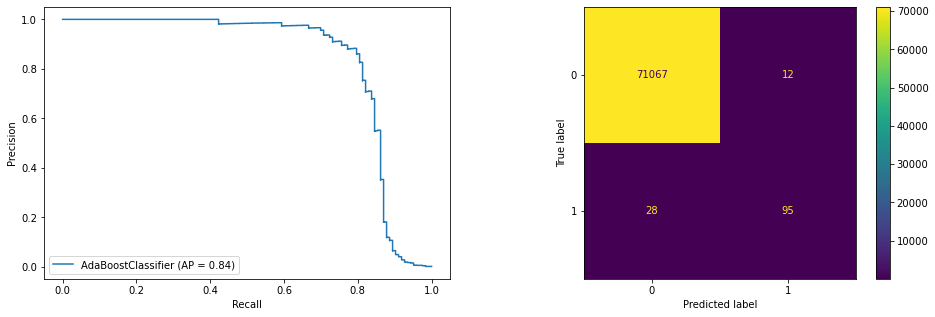

In [296]:
metric(adb_clf.best_estimator_, data2.X_test, data2.y_test)

## Random Forest

In [297]:
from sklearn.ensemble import RandomForestClassifier

In [298]:
rf = RandomForestClassifier()
rf.fit(data2.X_train,data2.y_train)

RandomForestClassifier()

P: 0.944,
R: 0.821,
F1-SCORE: 0.878


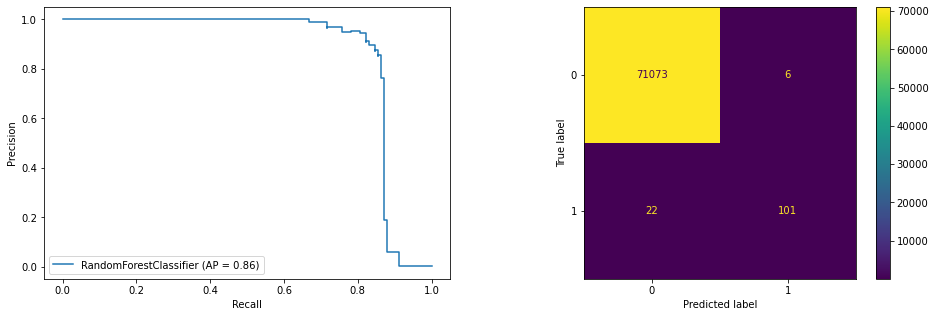

In [299]:
metric(rf, data2.X_test, data2.y_test)

## Voting

In [309]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

In [314]:
voting_clf = VotingClassifier([('svc',svc),('xgb',xgb_clf.best_estimator_),('rf',rf)],voting='soft',
                              weights=[.19,.39,.42])
voting_clf.estimators_ = [svc, xgb_clf.best_estimator_, rf]
voting_clf.le_ = LabelEncoder().fit(data2.y_test)
voting_clf.classes_ = voting_clf.le_.classes_

P: 0.935,
R: 0.821,
F1-SCORE: 0.874


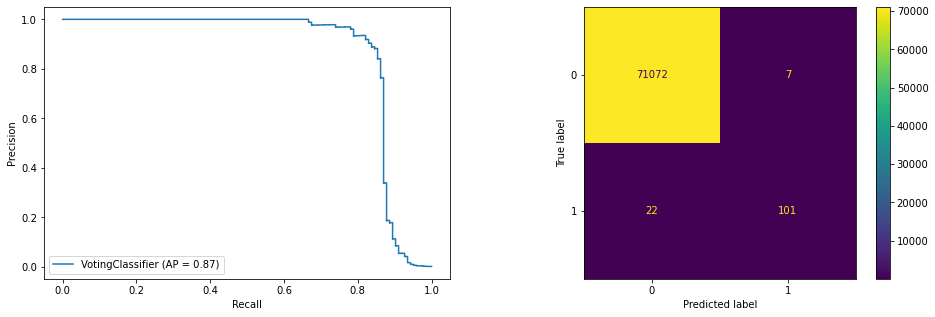

In [315]:
metric(voting_clf, data2.X_test, data2.y_test)